### Re-align blinks timeline

# Processed timestamp

In [159]:
j = []
if not j:
    print("j empty")

SyntaxError: invalid syntax (<ipython-input-159-8a0ef6b93b37>, line 2)

In [1]:
import pandas as pd

blinks_if = pd.read_csv("blink_if.csv")
blinks_if

Unnamed: 0   inds  EAR_vals         sec
0           148    148  0.164099    2.977867
1           178    178  0.142640    3.581489
2           179    179  0.096310    3.601610
3           180    180  0.066215    3.621730
4           181    181  0.052060    3.641851
..          ...    ...       ...         ...
281       10177  10177  0.039231  204.768612
282       10178  10178  0.062781  204.788732
283       10179  10179  0.061675  204.808853
284       10180  10180  0.102038  204.828974
285       10181  10181  0.147396  204.849095

[286 rows x 4 columns]

# Original Timestamp from EAR

In [140]:
blinks = pd.read_csv("blinks.csv")
blinks

Unnamed: 0                      TimeStamp  Blink_Flag_EAR  \
0               0  1970-01-01 00:00:00.000000000               0   
1               1  1970-01-01 00:00:00.040000000               0   
2               2  1970-01-01 00:00:00.060000000               0   
3               3  1970-01-01 00:00:00.080000000               0   
4               4  1970-01-01 00:00:00.100000000               0   
...           ...                            ...             ...   
10474       10474  1970-01-01 00:03:30.415200000               0   
10475       10475  1970-01-01 00:03:30.435000000               0   
10476       10476  1970-01-01 00:03:30.455200000               0   
10477       10477  1970-01-01 00:03:30.475000000               0   
10478       10478  1970-01-01 00:03:30.495000000               0   

       Cumulative_NumBlinks  Left_EAR  Right_EAR   EAR_Avg  
0                         0  0.252573   0.294372  0.273473  
1                         0  0.318981   0.321463  0.320222  
2                         0  0.279108   0.281942  0.280525  
3                         0  0.281942   0.289159  0.285550  
4                         0  0.320222   0.312843  0.316533  
...                     ...       ...        ...       ...  
10474                    58  0.240886   0.239236  0.240061  
10475                    58  0.241462   0.240886  0.241174  
10476                    58  0.221478   0.230089  0.225784  
10477                    58  0.240886   0.233263  0.237074  
10478                    58  0.271616   0.230829  0.251223  

[10479 rows x 7 columns]

In [86]:
# [i.split(" ")[1] for i in blinks['TimeStamp']]

In [141]:
def blink_preprocess(df):

    # the function's purpose is to convert the original blink csv's timestamp into a readable format

    # get only the time portions from the timestamp
    time_all_unsplit = [i.split(" ")[1].split(":") for i in df['TimeStamp']]

    ts_corr = []
    for i in time_all_unsplit:
        if int(int(i[1]) < 1):
            ts_corr.append(float(i[2]))
        else:
            ts_corr.append(int(i[1])*60+float(i[2]))

    df['TS_corrected'] = ts_corr
    df = df.rename(columns={'Unnamed: 0': 'Ind'})

    return df

In [142]:
blinks = blink_preprocess(blinks)
blinks

Ind                      TimeStamp  Blink_Flag_EAR  \
0          0  1970-01-01 00:00:00.000000000               0   
1          1  1970-01-01 00:00:00.040000000               0   
2          2  1970-01-01 00:00:00.060000000               0   
3          3  1970-01-01 00:00:00.080000000               0   
4          4  1970-01-01 00:00:00.100000000               0   
...      ...                            ...             ...   
10474  10474  1970-01-01 00:03:30.415200000               0   
10475  10475  1970-01-01 00:03:30.435000000               0   
10476  10476  1970-01-01 00:03:30.455200000               0   
10477  10477  1970-01-01 00:03:30.475000000               0   
10478  10478  1970-01-01 00:03:30.495000000               0   

       Cumulative_NumBlinks  Left_EAR  Right_EAR   EAR_Avg  TS_corrected  
0                         0  0.252573   0.294372  0.273473        0.0000  
1                         0  0.318981   0.321463  0.320222        0.0400  
2                         0  0.279108   0.281942  0.280525        0.0600  
3                         0  0.281942   0.289159  0.285550        0.0800  
4                         0  0.320222   0.312843  0.316533        0.1000  
...                     ...       ...        ...       ...           ...  
10474                    58  0.240886   0.239236  0.240061      210.4152  
10475                    58  0.241462   0.240886  0.241174      210.4350  
10476                    58  0.221478   0.230089  0.225784      210.4552  
10477                    58  0.240886   0.233263  0.237074      210.4750  
10478                    58  0.271616   0.230829  0.251223      210.4950  

[10479 rows x 8 columns]

In [149]:
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np

# number of standard deviations away from the rolling mean 
devs = 3

# size of the rolling window
roll_window = 100

# duration to be classified as a blink, in multiples of 20, eg. dur=2 means >=60ms or ([2+1]*20) ms. Time resolution is 20 ms
dur = 2

# pot_outliers will contain points below 3 sigma away from rolling EAR_Avg 
rolling = blinks['EAR_Avg'].rolling(roll_window).mean()
rolling_std = rolling - devs*rolling.std()

pot_outliers = blinks.loc[blinks['EAR_Avg'] < rolling_std]

# a first order estimation of contamination, a ratio of data 3 sigma away from mean to total data
contam = len(pot_outliers)/len(blinks)

# implement isolation forest
data_np = blinks['EAR_Avg'].to_numpy().reshape(-1,1)

model = IsolationForest(n_estimators=100, max_samples='auto', contamination=contam, random_state=42)

fit = model.fit(data_np)
decision = model.decision_function(data_np)
pred = model.predict(data_np)

# pred_df = pd.DataFrame({'dec':decision, 'pred':pred})
blinks_if_all = pd.DataFrame({'TS_corrected':blinks['TS_corrected'], 'Ori_ind': blinks['Ind'], 'EAR_Avg':blinks['EAR_Avg'], 'IF_Class':np.where(pred == -1, 1, 0)})
blinks_if = blinks_if_all[blinks_if_all['IF_Class'] == 1]
blinks_if_mean_removed = blinks_if[blinks_if['EAR_Avg'] < blinks_if_all['EAR_Avg'].mean()]
# ears = pd.DataFrame({'inds':pred_df.loc[pred_df['pred'] == -1].index, 'EAR_vals': blinks['EAR_Avg'][pred_df.loc[pred_df['pred'] == -1].index]})
# mean_ears = ears['EAR_vals'].mean()
# ears = ears[ears['EAR_vals'] < mean_ears]

# ears['ts'] = [i/49.78 for i in ears['inds']]

In [144]:
blinks_if_mean_removed.iloc[0:1]

TS_corrected  Ori_ind   EAR_Avg  IF_Class
148        3.9376      148  0.164099         1

In [95]:
epoch_dict = {'1': [0, 29512], '2': [29512, 42843], '3': [42843, 82842], '4': [82842, 104341], '5': [104341, 113262]}

In [116]:
for i,j in epoch_dict.items():
    print(i, round(j[0]*mult), round(j[1]*mult))

1 0 2938
2 2938 4265
3 4265 8248
4 8248 10388
5 10388 11276


In [156]:
j_1 = 8248
j_2 = 10388

In [153]:
blinks_imr

TS_corrected  Ori_ind   EAR_Avg  IF_Class
148          3.9376      148  0.164099         1
178          4.5374      178  0.142640         1
179          4.5574      179  0.096310         1
180          4.5774      180  0.066215         1
181          4.5972      181  0.052060         1
...             ...      ...       ...       ...
10177      204.4786    10177  0.039231         1
10178      204.4986    10178  0.062781         1
10179      204.5186    10179  0.061675         1
10180      204.5386    10180  0.102038         1
10181      204.5586    10181  0.147396         1

[286 rows x 4 columns]

In [150]:
blinks_imr = blinks_if_mean_removed

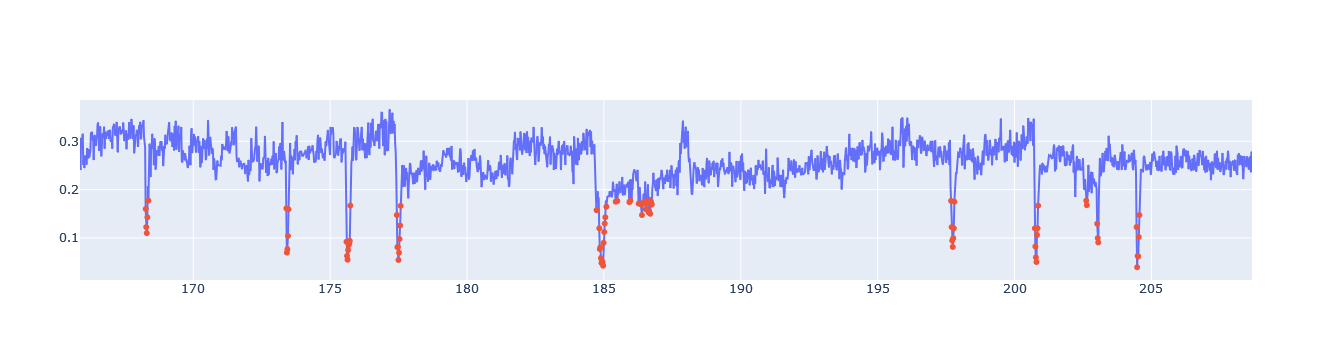

In [157]:
fig = go.Figure(
    data=go.Scatter(
        # x=df['seconds'][round(epochs[selection][0]*mult):round(epochs[selection][1]*mult)], 
        # y=df['EAR_Avg'][round(epochs[selection][0]*mult):round(epochs[selection][1]*mult)],
        x = blinks['TS_corrected'][j_1:j_2],
        y = blinks['EAR_Avg'][j_1:j_2],
        name="EAR value",
        showlegend=False
    ),
)
fig.add_trace(
    go.Scatter(
    #     x=blinks['sec'][(blinks['inds'] > round(epochs[selection][0]*mult)) & (blinks['inds'] < round(epochs[selection][1]*mult))],
    # #             x=blinks_if['sec'][blinks_if['sec'] > round(epochs[selection][0]*mult) and blinks_if['sec'] < round(epochs[selection][1]*mult)],
    #     y=blinks['EAR_vals'][(blinks['inds'] > round(epochs[selection][0]*mult)) & (blinks['inds'] < round(epochs[selection][1]*mult))],
        mode="markers",
        x = blinks_imr['TS_corrected'][(blinks_imr['Ori_ind'] > j_1) & (blinks_imr['Ori_ind'] < j_2)],
        y = blinks_imr['EAR_Avg'][(blinks_imr['Ori_ind'] > j_1) & (blinks_imr['Ori_ind'] < j_2)],
        name="Blinks",
        showlegend=False
    )
)
fig.show()

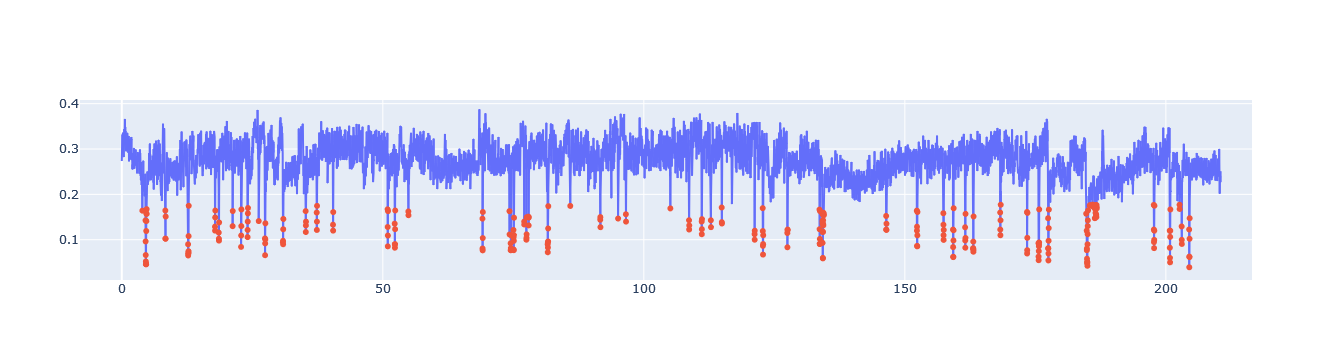

In [105]:
import plotly.graph_objs as go

fig = go.Figure(
    data=go.Scatter(
        # x=df['seconds'][round(epochs[selection][0]*mult):round(epochs[selection][1]*mult)], 
        # y=df['EAR_Avg'][round(epochs[selection][0]*mult):round(epochs[selection][1]*mult)],
        x = blinks['TS_corrected'],
        y = blinks['EAR_Avg'],
        name="EAR value",
        showlegend=False
    ),
)
fig.add_trace(
    go.Scatter(
    #     x=blinks['sec'][(blinks['inds'] > round(epochs[selection][0]*mult)) & (blinks['inds'] < round(epochs[selection][1]*mult))],
    # #             x=blinks_if['sec'][blinks_if['sec'] > round(epochs[selection][0]*mult) and blinks_if['sec'] < round(epochs[selection][1]*mult)],
    #     y=blinks['EAR_vals'][(blinks['inds'] > round(epochs[selection][0]*mult)) & (blinks['inds'] < round(epochs[selection][1]*mult))],
        mode="markers",
        x = blinks_if_mean_removed['TS_corrected'],
        y = blinks_if_mean_removed['EAR_Avg'],
        name="Blinks",
        showlegend=False
    )
)
fig.show()

In [15]:
len(pred[pred == -1])

384

In [ ]:
np.where(pred == -1)

In [46]:
blinks['IF'] = np.where(pred == -1, 1, 0)

In [24]:
# blinks = blinks[blinks['EAR_Avg'] < mean_ears]

In [56]:
blinks

Unnamed: 0                      TimeStamp  Blink_Flag_EAR  \
0               0  1970-01-01 00:00:00.000000000               0   
1               1  1970-01-01 00:00:00.040000000               0   
2               2  1970-01-01 00:00:00.060000000               0   
3               3  1970-01-01 00:00:00.080000000               0   
4               4  1970-01-01 00:00:00.100000000               0   
...           ...                            ...             ...   
10474       10474  1970-01-01 00:03:30.415200000               0   
10475       10475  1970-01-01 00:03:30.435000000               0   
10476       10476  1970-01-01 00:03:30.455200000               0   
10477       10477  1970-01-01 00:03:30.475000000               0   
10478       10478  1970-01-01 00:03:30.495000000               0   

       Cumulative_NumBlinks  Left_EAR  Right_EAR   EAR_Avg  IF  
0                         0  0.252573   0.294372  0.273473   0  
1                         0  0.318981   0.321463  0.320222   0  
2                         0  0.279108   0.281942  0.280525   0  
3                         0  0.281942   0.289159  0.285550   0  
4                         0  0.320222   0.312843  0.316533   0  
...                     ...       ...        ...       ...  ..  
10474                    58  0.240886   0.239236  0.240061   0  
10475                    58  0.241462   0.240886  0.241174   0  
10476                    58  0.221478   0.230089  0.225784   0  
10477                    58  0.240886   0.233263  0.237074   0  
10478                    58  0.271616   0.230829  0.251223   0  

[10479 rows x 8 columns]

In [48]:
blinks.iloc[np.where(pred == -1)]

Unnamed: 0                      TimeStamp  Blink_Flag_EAR  \
24             24  1970-01-01 00:00:00.599600000               0   
148           148  1970-01-01 00:00:03.937600000               0   
178           178  1970-01-01 00:00:04.537400000               0   
179           179  1970-01-01 00:00:04.557400000               0   
180           180  1970-01-01 00:00:04.577400000               0   
...           ...                            ...             ...   
10177       10177  1970-01-01 00:03:24.478600000               0   
10178       10178  1970-01-01 00:03:24.498600000               0   
10179       10179  1970-01-01 00:03:24.518600000               0   
10180       10180  1970-01-01 00:03:24.538600000               0   
10181       10181  1970-01-01 00:03:24.558600000               0   

       Cumulative_NumBlinks  Left_EAR  Right_EAR   EAR_Avg  IF  
24                        0  0.374394   0.358535  0.366465   1  
148                       0  0.153732   0.174466  0.164099   1  
178                       1  0.148398   0.136882  0.142640   1  
179                       1  0.084654   0.107967  0.096310   1  
180                       1  0.070198   0.062232  0.066215   1  
...                     ...       ...        ...       ...  ..  
10177                    57  0.040000   0.038462  0.039231   1  
10178                    57  0.059952   0.065609  0.062781   1  
10179                    57  0.057692   0.065658  0.061675   1  
10180                    57  0.104076   0.100000  0.102038   1  
10181                    57  0.145707   0.149085  0.147396   1  

[384 rows x 8 columns]

In [25]:
blinks

Unnamed: 0                      TimeStamp  Blink_Flag_EAR  \
147           147  1970-01-01 00:00:03.917800000               0   
148           148  1970-01-01 00:00:03.937600000               0   
178           178  1970-01-01 00:00:04.537400000               0   
179           179  1970-01-01 00:00:04.557400000               0   
180           180  1970-01-01 00:00:04.577400000               0   
...           ...                            ...             ...   
10177       10177  1970-01-01 00:03:24.478600000               0   
10178       10178  1970-01-01 00:03:24.498600000               0   
10179       10179  1970-01-01 00:03:24.518600000               0   
10180       10180  1970-01-01 00:03:24.538600000               0   
10181       10181  1970-01-01 00:03:24.558600000               0   

       Cumulative_NumBlinks  Left_EAR  Right_EAR   EAR_Avg  IF  
147                       0  0.180000   0.181401  0.180700   0  
148                       0  0.153732   0.174466  0.164099   1  
178                       1  0.148398   0.136882  0.142640   1  
179                       1  0.084654   0.107967  0.096310   1  
180                       1  0.070198   0.062232  0.066215   1  
...                     ...       ...        ...       ...  ..  
10177                    57  0.040000   0.038462  0.039231   1  
10178                    57  0.059952   0.065609  0.062781   1  
10179                    57  0.057692   0.065658  0.061675   1  
10180                    57  0.104076   0.100000  0.102038   1  
10181                    57  0.145707   0.149085  0.147396   1  

[303 rows x 8 columns]

In [27]:
ears

inds  EAR_vals          ts
148      148  0.164099    2.973082
178      178  0.142640    3.575733
179      179  0.096310    3.595822
180      180  0.066215    3.615910
181      181  0.052060    3.635998
...      ...       ...         ...
10177  10177  0.039231  204.439534
10178  10178  0.062781  204.459622
10179  10179  0.061675  204.479711
10180  10180  0.102038  204.499799
10181  10181  0.147396  204.519888

[286 rows x 3 columns]

In [21]:
blinks.sum()

Unnamed: 0                                                       54899481
TimeStamp               1970-01-01 00:00:00.0000000001970-01-01 00:00:...
Blink_Flag_EAR                                                         58
Cumulative_NumBlinks                                               295029
Left_EAR                                                      2881.962169
Right_EAR                                                     2850.356545
EAR_Avg                                                       2866.159357
IF                                                                    384
dtype: object

In [8]:
len(blinks)

10479

In [5]:
len(decision)

10479

In [41]:
epoch_dict = {'1': [0, 29512], '2': [29512, 42843], '3': [42843, 82842], '4': [82842, 104341], '5': [104341, 113262]}

In [43]:
eye_fr = 49.78
freq = 500
mult = eye_fr/freq
mult

0.09956

In [45]:
epoch_dict['1'][1]*mult

2938.21472

In [61]:
time_all_unsplit = [i.split(" ")[1].split(":") for i in blinks['TimeStamp']]

In [71]:
ts_corr = []
for i in time_all_unsplit:
    if int(i[1]) < 1:
        ts_corr.append(float(i[2]))
    else:
        ts_corr.append(int(i[1])*60+float(i[2]))

In [73]:
blinks

Unnamed: 0                      TimeStamp  Blink_Flag_EAR  \
0               0  1970-01-01 00:00:00.000000000               0   
1               1  1970-01-01 00:00:00.040000000               0   
2               2  1970-01-01 00:00:00.060000000               0   
3               3  1970-01-01 00:00:00.080000000               0   
4               4  1970-01-01 00:00:00.100000000               0   
...           ...                            ...             ...   
10474       10474  1970-01-01 00:03:30.415200000               0   
10475       10475  1970-01-01 00:03:30.435000000               0   
10476       10476  1970-01-01 00:03:30.455200000               0   
10477       10477  1970-01-01 00:03:30.475000000               0   
10478       10478  1970-01-01 00:03:30.495000000               0   

       Cumulative_NumBlinks  Left_EAR  Right_EAR   EAR_Avg  IF  
0                         0  0.252573   0.294372  0.273473   0  
1                         0  0.318981   0.321463  0.320222   0  
2                         0  0.279108   0.281942  0.280525   0  
3                         0  0.281942   0.289159  0.285550   0  
4                         0  0.320222   0.312843  0.316533   0  
...                     ...       ...        ...       ...  ..  
10474                    58  0.240886   0.239236  0.240061   0  
10475                    58  0.241462   0.240886  0.241174   0  
10476                    58  0.221478   0.230089  0.225784   0  
10477                    58  0.240886   0.233263  0.237074   0  
10478                    58  0.271616   0.230829  0.251223   0  

[10479 rows x 8 columns]

In [74]:
blinks['ts_corr'] = ts_corr

In [22]:
blinks_if['ts'] = pd.to_datetime(blinks['TimeStamp']).dt.time[blinks_if['inds']].tolist()
blinks_if

Unnamed: 0   inds  EAR_vals         sec               ts
0           148    148  0.164099    2.977867  00:00:03.937600
1           178    178  0.142640    3.581489  00:00:04.537400
2           179    179  0.096310    3.601610  00:00:04.557400
3           180    180  0.066215    3.621730  00:00:04.577400
4           181    181  0.052060    3.641851  00:00:04.597200
..          ...    ...       ...         ...              ...
281       10177  10177  0.039231  204.768612  00:03:24.478600
282       10178  10178  0.062781  204.788732  00:03:24.498600
283       10179  10179  0.061675  204.808853  00:03:24.518600
284       10180  10180  0.102038  204.828974  00:03:24.538600
285       10181  10181  0.147396  204.849095  00:03:24.558600

[286 rows x 5 columns]

TypeError: float() argument must be a string or a number, not 'datetime.time'

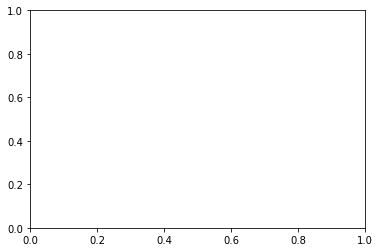

In [26]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(blinks_if['ts'], blinks_if['EAR_vals'])

In [21]:
blinks_if.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  286 non-null    int64  
 1   inds        286 non-null    int64  
 2   EAR_vals    286 non-null    float64
 3   sec         286 non-null    float64
 4   ts          286 non-null    object 
dtypes: float64(2), int64(2), object(1)
memory usage: 11.3+ KB


### Put Brodmann Info on ADELE

In [7]:
brainmap = {
    'Fpz':'Prefrontal Cortex',
    'Fp1':'Prefrontal Cortex',
    'Fp2':'Prefrontal Cortex',
    'AF7':'Prefrontal Cortex',
    'AF3':'Prefrontal Cortex',
    'AFz':'Prefrontal Cortex',
    'AF4':'Prefrontal Cortex',
    'AF8':'Prefrontal Cortex',
    'F7' :'Premotor Cortex',
    'F5':'Premotor Cortex',
    'F3':'Premotor Cortex',
    'F1':'Premotor Cortex',
    'Fz':'Premotor Cortex',
    'F2':'Premotor Cortex',
    'F4':'Premotor Cortex',
    'F6':'Premotor Cortex',
    'F8':'Premotor Cortex',
    'FT9':'Auditory Association Area',
    'FT7':'Brocas Area',
    'FC5':'Primary Motor Cortex',
    'FC3':'Primary Motor Cortex',
    'FC1':'Primary Motor Cortex',
    'FCz':'Primary Motor Cortex',
    'FC2':'Primary Motor Cortex',
    'FC4':'Primary Motor Cortex',
    'FC6':'Primary Motor Cortex',
    'FT8': 'Brocas Area',
    'FT10':'Auditory Association Area',
    'T7':'Auditory Cortex',
    'C5':'Primary Sensory Cortex',
    'C3':'Primary Sensory Cortex',
    'C1':'Primary Sensory Cortex',
    'Cz':'Primary Sensory Cortex',
    'C2':'Primary Sensory Cortex',
    'C4':'Primary Sensory Cortex',
    'C6':'Primary Sensory Cortex',
    'T8':'Auditory Cortex',
    'TP7':'Wernickes Area',
    'CP5':'Somatic Sensory Association Area',
    'CP3':'Somatic Sensory Association Area',
    'CP1':'Somatic Sensory Association Area',
    'CPz':'Somatic Sensory Association Area',
    'CP2':'Somatic Sensory Association Area',
    'CP4':'Somatic Sensory Association Area',
    'CP6':'Somatic Sensory Association Area',
    'TP8':'Wernickes Area',
    'TP10':'Wernickes Area',
    'P7':'Somatic Sensory Association Area',
    'P5':'Somatic Sensory Association Area',
    'P3':'Somatic Sensory Association Area',
    'P1':'Somatic Sensory Association Area',
    'Pz':'Somatic Sensory Association Area',
    'P2':'Somatic Sensory Association Area',
    'P4':'Somatic Sensory Association Area',
    'P6':'Somatic Sensory Association Area',
    'P8':'Somatic Sensory Association Area',
    'PO7':'Visual Association Area',
    'PO3':'Visual Association Area',
    'POz':'Visual Association Area',
    'PO4':'Visual Association Area',
    'PO8':'Visual Association Area',
    'O1':'Visual Cortex',
    'Oz':'Visual Cortex',
    'O2':'Visual Cortex'}

In [19]:
vals = list(brainmap.values())

In [17]:
elec = list(brainmap.keys())

In [41]:
bm_df = pd.DataFrame(data=[elec, vals]).transpose()
bm_df.columns = ["Name", "Region"]
bm_df

Name                   Region
0   Fpz        Prefrontal Cortex
1   Fp1        Prefrontal Cortex
2   Fp2        Prefrontal Cortex
3   AF7        Prefrontal Cortex
4   AF3        Prefrontal Cortex
..  ...                      ...
59  PO4  Visual Association Area
60  PO8  Visual Association Area
61   O1            Visual Cortex
62   Oz            Visual Cortex
63   O2            Visual Cortex

[64 rows x 2 columns]

In [52]:
type(bm_df['Name'])

pandas.core.series.Series

In [60]:
[bm_df['Name']].index('Fp2')

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [66]:
areamap = {
    'Prefrontal Cortex':'Involved in decision making and abstract thought',
    'Premotor Cortex':'Involved in planning of movement',
    'Brocas Area':'Responsible for speech production',
    'Auditory Cortex':'Processes sound',
    'Auditory Association Area':'Responsible for high level processing of sound, such as memory',
    'Primary Motor Cortex':'Executes Movement',
    'Primary Sensory Cortex':'Main receptive area for the senses, especially touch',
    'Wernickes Area':'Involved in understanding speech',
    'Somatic Sensory Association Area':'Involved in high level touch interpretation',
    'Visual Association Area':'Involved in high level processing of visual stimuli',
    'Visual Cortex':'Processes visual stimuli'
    }

In [75]:
region

[]

In [78]:
region, function = [], []
for item in df['Name']:
    print(brainmap[item], areamap[brainmap[item]])
    # region_ind = list(bm_df['Name']).index(item)
    # # print(item, bm_df['Region'][region_ind], areamap[bm_df['Region'][region_ind]])
    # region.append(bm_df['Region'][region_ind])
    # function.append(areamap[bm_df['Region'][region_ind]])
    # print(item, bm_df['Region'].list([bm_df['Name']]).index(item))

Prefrontal Cortex Involved in decision making and abstract thought
Prefrontal Cortex Involved in decision making and abstract thought
Premotor Cortex Involved in planning of movement
Premotor Cortex Involved in planning of movement
Primary Sensory Cortex Main receptive area for the senses, especially touch
Primary Sensory Cortex Main receptive area for the senses, especially touch
Somatic Sensory Association Area Involved in high level touch interpretation
Somatic Sensory Association Area Involved in high level touch interpretation
Visual Cortex Processes visual stimuli
Visual Cortex Processes visual stimuli
Premotor Cortex Involved in planning of movement
Premotor Cortex Involved in planning of movement
Auditory Cortex Processes sound
Auditory Cortex Processes sound
Somatic Sensory Association Area Involved in high level touch interpretation
Somatic Sensory Association Area Involved in high level touch interpretation
Premotor Cortex Involved in planning of movement
Primary Sensory Cor

In [71]:
df

Unnamed: 0  Name             x             y         z
0            0   Fp1  8.078400e+01  2.613300e+01  -4.00108
1            1   Fp2  8.078400e+01 -2.613300e+01  -4.00108
2            2    F3  5.755110e+01  4.820040e+01  39.86970
3            3    F4  5.758400e+01 -4.814260e+01  39.89200
4            4    C3  3.868130e-15  6.317130e+01  56.87170
..         ...   ...           ...           ...       ...
59          59   PO8 -6.872090e+01 -4.966890e+01  -5.95298
60          60   Fpz  8.498120e+01  0.000000e+00  -1.78604
61          61   CPz -3.292790e+01 -4.032500e-15  78.36300
62          62   POz -7.902550e+01 -9.677840e-15  31.30440
63          63  TP10 -2.330160e+01 -7.007580e+01 -42.08820

[64 rows x 5 columns]

In [73]:
df['Region'] = region
df['Function'] = function
df

Unnamed: 0  Name             x             y         z  \
0            0   Fp1  8.078400e+01  2.613300e+01  -4.00108   
1            1   Fp2  8.078400e+01 -2.613300e+01  -4.00108   
2            2    F3  5.755110e+01  4.820040e+01  39.86970   
3            3    F4  5.758400e+01 -4.814260e+01  39.89200   
4            4    C3  3.868130e-15  6.317130e+01  56.87170   
..         ...   ...           ...           ...       ...   
59          59   PO8 -6.872090e+01 -4.966890e+01  -5.95298   
60          60   Fpz  8.498120e+01  0.000000e+00  -1.78604   
61          61   CPz -3.292790e+01 -4.032500e-15  78.36300   
62          62   POz -7.902550e+01 -9.677840e-15  31.30440   
63          63  TP10 -2.330160e+01 -7.007580e+01 -42.08820   

                              Region  \
0                  Prefrontal Cortex   
1                  Prefrontal Cortex   
2                    Premotor Cortex   
3                    Premotor Cortex   
4             Primary Sensory Cortex   
..                               ...   
59           Visual Association Area   
60                 Prefrontal Cortex   
61  Somatic Sensory Association Area   
62           Visual Association Area   
63                    Wernickes Area   

                                             Function  
0    Involved in decision making and abstract thought  
1    Involved in decision making and abstract thought  
2                    Involved in planning of movement  
3                    Involved in planning of movement  
4   Main receptive area for the senses, especially...  
..                                                ...  
59  Involved in high level processing of visual st...  
60   Involved in decision making and abstract thought  
61        Involved in high level touch interpretation  
62  Involved in high level processing of visual st...  
63                   Involved in understanding speech  

[64 rows x 7 columns]

In [6]:
import pandas as pd

df = pd.read_csv("brain_df.csv")
df.head()

Unnamed: 0 Name             x        y         z
0           0  Fp1  8.078400e+01  26.1330  -4.00108
1           1  Fp2  8.078400e+01 -26.1330  -4.00108
2           2   F3  5.755110e+01  48.2004  39.86970
3           3   F4  5.758400e+01 -48.1426  39.89200
4           4   C3  3.868130e-15  63.1713  56.87170

In [42]:
df['Name'].compare(bm_df['Name'])

self other
0    Fp1   Fpz
1    Fp2   Fp1
2     F3   Fp2
3     F4   AF7
4     C3   AF3
..   ...   ...
59   PO8   PO4
60   Fpz   PO8
61   CPz    O1
62   POz    Oz
63  TP10    O2

[62 rows x 2 columns]

In [10]:
len(df)

64

In [8]:
    epoch_text = [["it's secure okay he was hurt the timer",
  'yeah',
  "it's pretty good i can it's pretty good",
  'uncountable right now',
a  'what did you do today',
  'do some research worked on my slides okay',
  "would you you could like move that if you want to like put your back against that and then i'll be able to see you easier",
  'natalie',
  "the law in video and everything's being recorded",
  'please',
  'he talks'],
 ['i made him fun i had memes oh really',
  'the one name presently to your team',
  "i'll probably present it next week",
  'but'],
 ["the worst thing is to be ignorant of your limitations so you just like go up there and start expounding on things i'm like oh yeah we can do everything will be new orleans and we're so cool and amazing and yeah that's like you know just so everyone knows like we know or i",
  "i know that this there are this isn't like a magic bullet you know what i mean this there are some drawbacks to these approaches and limitations and whatnot",
  'you guys are crazy i guess it is',
  'remember that',
  'what were they like three months ago',
  'have to give it to you so',
  'like asleep',
  'yeah like a stone slate',
  't-bone backers',
  'online',
  'jesus you would like it she was hoping to bring it here but'],
 ["so here's hoping",
  "where's the play tomorrow",
  'wow',
  "you'll like it",
  "you didn't bring it",
  'a bunch of material',
  "i think that's good",
  "it's slow and powdery may not have recorded that spit",
  'we',
  'we gotta take all this stuff up'],
 ['haha yeah yeah yeah']]

In [14]:
from dbpunctuator.inference import Inference, InferenceArguments
from dbpunctuator.utils import DEFAULT_ENGLISH_TAG_PUNCTUATOR_MAP

def return_epoch(text):
    args = InferenceArguments(
            model_name_or_path="Qishuai/distilbert_punctuator_en",
            tokenizer_name="Qishuai/distilbert_punctuator_en",
            tag2punctuator=DEFAULT_ENGLISH_TAG_PUNCTUATOR_MAP
        )

    punctuator_model = Inference(inference_args=args, 
                                 verbose=False)
    
    for i,j in enumerate(text):
        epoch_text[i] = punctuator_model.punctuation(j)[0]
        
    return epoch_text

In [15]:
return_epoch(epoch_text)

2022-01-04 18:36:02,000 - INFO - inference_interface.py:75 - inference_interface._produce_server - 4632 - set up punctuator
2022-01-04 18:36:03,815 - INFO - inference_interface.py:88 - inference_interface._produce_server - 4632 - start running punctuator
2022-01-04 18:36:09,907 - INFO - inference_interface.py:91 - inference_interface._produce_server - 4632 - start client


[["It's secure okay he was hurt the timer",
  'Yeah.,',
  "It's pretty good i can. It's pretty good.",
  'Uncountable right now.',
  'What did you do today?',
  'Do some research worked on my slides. Okay.',
  "Would you you could like move that if you want to like, put your back against that and then i'll be able to see you easier.",
  'Natalie..',
  "The law in video and everything's being recorded.",
  'Please.',
  'He talks.'],
 ['I made him fun. I had memes oh, really..',
  'The one name presently to your team.',
  "I'll probably present it next week.",
  'But'],
 ["The worst thing is to be ignorant of your limitations so you just like, go up there and start expounding on things i'm like, oh yeah, we can do everything will be new orleans and we're so cool and amazing and yeah, that's like, you know just so everyone knows, like we know or i",
  "I know that this there are this isn't like a magic bullet you know what i mean? This there are some drawbacks to these approaches and limi

In [10]:
for i,j in enumerate(epoch_text):
    # print(j)
    epoch_text[i] = punctuator_model.punctuation(j)[0]
    # print(punctuator_model.punctuation(j)[0])
    
epoch_text

[["It's secure okay he was hurt the timer",
  'Yeah.',
  "It's pretty good i can. It's pretty good.",
  'Uncountable right now.',
  'What did you do today?',
  'Do some research worked on my slides. Okay.',
  "Would you you could like move that if you want to like, put your back against that and then i'll be able to see you easier.",
  'Natalie.',
  "The law in video and everything's being recorded.",
  'Please.',
  'He talks.'],
 ['I made him fun. I had memes oh, really.',
  'The one name presently to your team.',
  "I'll probably present it next week.",
  'But'],
 ["The worst thing is to be ignorant of your limitations so you just like, go up there and start expounding on things i'm like, oh yeah, we can do everything will be new orleans and we're so cool and amazing and yeah, that's like, you know just so everyone knows, like we know or i",
  "I know that this there are this isn't like a magic bullet you know what i mean? This there are some drawbacks to these approaches and limitat

# Audio Preprocess 

In [2]:
import os
import sys
import wave
import json
from vosk import Model, KaldiRecognizer, SetLogLevel
# import Word
import subprocess
from detoxify import Detoxify
import pandas as pd
from dbpunctuator.inference import Inference, InferenceArguments
from dbpunctuator.utils import DEFAULT_ENGLISH_TAG_PUNCTUATOR_MAP

def audio_to_text(audio_file):

    if not os.path.exists(audio_file):
        video_path = ('/').join(audio_file.split('/')[:-1]) + '/fullstream.mp4 '
        convert = "ffmpeg -i " + video_path + "-ab 160k -ac 2 -ar 44110 -vn " + audio_file
        subprocess.call(convert)

    SetLogLevel(0)

    model = Model("../vosk-model-en-us-0.22")
    print("Audio to text model loaded...")

    audio = audio_file

    sample_rate=16000
    #     model = Model("model_aspire")
    # model = Model("model_english")
    rec = KaldiRecognizer(model, sample_rate)
    rec.SetWords(True)

    process = subprocess.Popen(['ffmpeg', '-loglevel', 'quiet', '-i',
                                audio,
                                '-ar', str(sample_rate) , '-ac', '1', '-f', 's16le', '-'],
                                stdout=subprocess.PIPE)

    results = []
    result = ""

    # recognize speech using vosk model
    while True:
        data = process.stdout.read(4000)
        if len(data) == 0:
            break
        if rec.AcceptWaveform(data):
            part_result = json.loads(rec.Result())
            # print(part_result)
            results.append(part_result)
            
                    
            if part_result['text'] != '':
                result += part_result['text'] + "\n\n"
    #             temp += r['text'] + ' '

    part_result = json.loads(rec.FinalResult())
    results.append(part_result)
    
    return results

#     print("Processing text into epochs...")

#     lines = []
#     for obj in results:
#         if obj['text'] == '':
#             continue
#         # print("start: " + str(obj['result'][0]['start']) + ". End: " + str(obj['result'][-1]['end']))
#         # print(obj['text'])
#         lines.append([obj['result'][0]['start'],obj['result'][-1]['end'],obj['text']])

#     epoch_text = [[] for x in range(len(epoch_dict))]
#     for line in lines:
#         for i,j in enumerate(epoch_dict.values()):
#             if line[0] > j[0]/500 and line[1] < j[1]/500:
#                 epoch_text[i].append(line[2])

#     print("Creating toxicity reports...")

#     for i,j in enumerate(epoch_text):
#         if j:
#             tox = Detoxify('original').predict(j)
#             df = pd.DataFrame(tox)*100
#             epoch_text[i].append(df.mean())
#         # epoch_text[i] = punctuator_model.punctuation(j)[0]
    
    # return epoch_text

In [1]:
results_df = audio_to_text("../../static/2022_01_14_T05_U002/tobiiaudio.wav")

NameError: name 'audio_to_text' is not defined

In [42]:
results_df = [{'result': [{'conf': 0.883019,
    'end': 2.55,
    'start': 2.07,
    'word': 'coachella'}],
  'text': 'coachella'},
 {'result': [{'conf': 0.756904, 'end': 4.41, 'start': 4.29, 'word': "you're"},
   {'conf': 1.0, 'end': 4.68, 'start': 4.41, 'word': 'free'}],
  'text': "you're free"},
 {'result': [{'conf': 1.0, 'end': 10.32, 'start': 9.87, 'word': 'presumably'},
   {'conf': 1.0, 'end': 10.56, 'start': 10.32, 'word': "there'll"},
   {'conf': 1.0, 'end': 10.68, 'start': 10.56, 'word': 'be'},
   {'conf': 1.0, 'end': 10.86, 'start': 10.68, 'word': 'some'},
   {'conf': 1.0, 'end': 11.19, 'start': 10.86, 'word': 'motion'},
   {'conf': 1.0, 'end': 11.73, 'start': 11.19, 'word': 'artifact'},
   {'conf': 1.0, 'end': 12.09, 'start': 11.73, 'word': 'but'}],
  'text': "presumably there'll be some motion artifact but"},
 {'result': [{'conf': 0.845165,
    'end': 21.047666,
    'start': 14.82,
    'word': 'the'},
   {'conf': 1.0, 'end': 21.18, 'start': 21.06, 'word': 'let'},
   {'conf': 1.0, 'end': 21.24, 'start': 21.18, 'word': 'me'},
   {'conf': 1.0, 'end': 21.33, 'start': 21.24, 'word': 'know'},
   {'conf': 0.969855, 'end': 21.48, 'start': 21.33, 'word': 'when'}],
  'text': 'the let me know when'},
 {'result': [{'conf': 0.668295, 'end': 22.92, 'start': 22.62, 'word': 'okay'}],
  'text': 'okay'},
 {'result': [{'conf': 1.0, 'end': 24.84, 'start': 24.63, 'word': "it's"},
   {'conf': 0.824529, 'end': 24.99, 'start': 24.84, 'word': 'going'},
   {'conf': 0.824529, 'end': 25.05, 'start': 24.99, 'word': 'to'},
   {'conf': 1.0, 'end': 25.35, 'start': 25.05, 'word': 'probably'},
   {'conf': 1.0, 'end': 25.47, 'start': 25.35, 'word': 'going'},
   {'conf': 1.0, 'end': 25.53, 'start': 25.47, 'word': 'to'},
   {'conf': 1.0, 'end': 25.77, 'start': 25.53, 'word': 'start'},
   {'conf': 1.0, 'end': 25.89, 'start': 25.77, 'word': 'in'},
   {'conf': 1.0, 'end': 26.19, 'start': 25.89, 'word': 'like'},
   {'conf': 1.0, 'end': 26.73, 'start': 26.49, 'word': 'five'},
   {'conf': 1.0, 'end': 27.18, 'start': 26.73, 'word': 'seconds'}],
  'text': "it's going to probably going to start in like five seconds"},
 {'result': [{'conf': 1.0, 'end': 29.7, 'start': 29.52, 'word': 'it'},
   {'conf': 1.0, 'end': 30.06, 'start': 29.7, 'word': 'started'},
   {'conf': 1.0, 'end': 30.27, 'start': 30.06, 'word': 'now'}],
  'text': 'it started now'},
 {'result': [{'conf': 1.0, 'end': 51.6, 'start': 31.53, 'word': 'the'}],
  'text': 'the'},
 {'result': [{'conf': 1.0, 'end': 71.76, 'start': 51.63, 'word': 'the'}],
  'text': 'the'},
 {'result': [{'conf': 1.0, 'end': 91.92, 'start': 71.79, 'word': 'the'}],
  'text': 'the'},
 {'result': [{'conf': 1.0, 'end': 112.08, 'start': 91.95, 'word': 'the'}],
  'text': 'the'},
 {'result': [{'conf': 1.0, 'end': 132.24, 'start': 112.11, 'word': 'the'}],
  'text': 'the'},
 {'result': [{'conf': 1.0, 'end': 152.4, 'start': 132.27, 'word': 'the'}],
  'text': 'the'},
 {'result': [{'conf': 1.0, 'end': 172.56, 'start': 152.43, 'word': 'the'}],
  'text': 'the'},
 {'result': [{'conf': 1.0, 'end': 192.72, 'start': 172.59, 'word': 'the'}],
  'text': 'the'},
 {'result': [{'conf': 1.0, 'end': 212.88, 'start': 192.75, 'word': 'the'}],
  'text': 'the'},
 {'result': [{'conf': 1.0, 'end': 233.04, 'start': 212.91, 'word': 'the'}],
  'text': 'the'},
 {'result': [{'conf': 1.0, 'end': 253.2, 'start': 233.07, 'word': 'the'}],
  'text': 'the'},
 {'result': [{'conf': 1.0, 'end': 273.36, 'start': 253.23, 'word': 'the'}],
  'text': 'the'},
 {'result': [{'conf': 1.0, 'end': 293.52, 'start': 273.39, 'word': 'the'}],
  'text': 'the'},
 {'result': [{'conf': 1.0, 'end': 313.68, 'start': 293.55, 'word': 'the'}],
  'text': 'the'},
 {'result': [{'conf': 1.0, 'end': 333.84, 'start': 313.71, 'word': 'the'}],
  'text': 'the'},
 {'result': [{'conf': 1.0, 'end': 351.447715, 'start': 333.87, 'word': 'the'},
   {'conf': 1.0, 'end': 352.11, 'start': 351.54, 'word': 'reflections'},
   {'conf': 1.0, 'end': 352.290762, 'start': 352.11, 'word': 'on'},
   {'conf': 0.896, 'end': 352.5, 'start': 352.290762, 'word': 'that'},
   {'conf': 1.0, 'end': 353.55, 'start': 353.4, 'word': 'i'},
   {'conf': 0.779749, 'end': 353.7, 'start': 353.55, 'word': "don't"},
   {'conf': 0.779749, 'end': 353.845488, 'start': 353.7, 'word': 'know'},
   {'conf': 1.0, 'end': 353.911582, 'start': 353.845488, 'word': 'if'},
   {'conf': 0.852394, 'end': 354.0, 'start': 353.911582, 'word': 'you'}],
  'text': "the reflections on that i don't know if you"},
 {'result': [{'conf': 1.0, 'end': 354.33, 'start': 354.03, 'word': 'notice'},
   {'conf': 1.0, 'end': 354.42, 'start': 354.33, 'word': 'the'},
   {'conf': 1.0, 'end': 354.96, 'start': 354.42, 'word': 'timer'},
   {'conf': 1.0, 'end': 355.11, 'start': 354.96, 'word': 'i'},
   {'conf': 0.957799, 'end': 355.44, 'start': 355.11, 'word': 'won'},
   {'conf': 1.0, 'end': 355.59, 'start': 355.44, 'word': 'with'},
   {'conf': 1.0, 'end': 355.83, 'start': 355.59, 'word': 'zero'},
   {'conf': 1.0, 'end': 356.04, 'start': 355.83, 'word': 'point'},
   {'conf': 1.0, 'end': 356.31, 'start': 356.04, 'word': 'zero'},
   {'conf': 1.0, 'end': 356.52, 'start': 356.31, 'word': 'one'},
   {'conf': 1.0, 'end': 356.85, 'start': 356.52, 'word': 'seconds'},
   {'conf': 1.0, 'end': 357.24, 'start': 356.85, 'word': 'left'}],
  'text': 'notice the timer i won with zero point zero one seconds left'},
 {'result': [{'conf': 1.0, 'end': 359.16, 'start': 358.8, 'word': 'my'},
   {'conf': 1.0, 'end': 359.61, 'start': 359.16, 'word': 'heart'},
   {'conf': 1.0, 'end': 359.97, 'start': 359.64, 'word': 'is'},
   {'conf': 1.0, 'end': 361.05, 'start': 360.15, 'word': 'hammering'},
   {'conf': 1.0, 'end': 364.650322, 'start': 361.41, 'word': 'the'},
   {'conf': 0.902838, 'end': 364.8, 'start': 364.650322, 'word': 'head'},
   {'conf': 1.0, 'end': 364.89, 'start': 364.8, 'word': 'of'},
   {'conf': 1.0, 'end': 365.13, 'start': 364.89, 'word': 'your'},
   {'conf': 1.0, 'end': 365.4, 'start': 365.13, 'word': 'one'},
   {'conf': 1.0, 'end': 365.91, 'start': 365.4, 'word': 'forty'}],
  'text': 'my heart is hammering the head of your one forty'},
 {'result': [{'conf': 0.822296,
    'end': 368.37,
    'start': 366.96,
    'word': 'yeah'},
   {'conf': 0.833767, 'end': 369.09, 'start': 368.43, 'word': 'disadvantage'},
   {'conf': 1.0, 'end': 369.3, 'start': 369.12, 'word': 'is'},
   {'conf': 1.0, 'end': 369.72, 'start': 369.3, 'word': 'moving'},
   {'conf': 1.0, 'end': 371.25, 'start': 370.62, 'word': 'right'},
   {'conf': 1.0, 'end': 371.88, 'start': 371.25, 'word': 'yeah'},
   {'conf': 0.424334, 'end': 373.337578, 'start': 373.02, 'word': 'you'},
   {'conf': 0.79318, 'end': 373.543975, 'start': 373.337578, 'word': 'it'},
   {'conf': 1.0, 'end': 373.83, 'start': 373.543975, 'word': 'used'},
   {'conf': 1.0, 'end': 373.92, 'start': 373.83, 'word': 'to'},
   {'conf': 1.0, 'end': 374.07, 'start': 373.92, 'word': 'be'},
   {'conf': 1.0, 'end': 374.34, 'start': 374.07, 'word': 'that'},
   {'conf': 1.0, 'end': 374.46, 'start': 374.34, 'word': 'in'},
   {'conf': 1.0, 'end': 374.88, 'start': 374.46, 'word': 'chess'},
   {'conf': 1.0, 'end': 375.36, 'start': 374.88, 'word': 'online'},
   {'conf': 1.0, 'end': 375.48, 'start': 375.36, 'word': 'you'},
   {'conf': 1.0, 'end': 375.75, 'start': 375.48, 'word': 'could'},
   {'conf': 1.0, 'end': 376.17, 'start': 375.75, 'word': 'pre'},
   {'conf': 1.0, 'end': 376.56, 'start': 376.17, 'word': 'move'},
   {'conf': 1.0, 'end': 377.97, 'start': 377.07, 'word': 'and'},
   {'conf': 1.0, 'end': 378.75, 'start': 378.09, 'word': 'where'},
   {'conf': 1.0, 'end': 378.93, 'start': 378.75, 'word': 'if'},
   {'conf': 1.0, 'end': 379.11, 'start': 378.93, 'word': 'you'},
   {'conf': 1.0, 'end': 379.38, 'start': 379.14, 'word': 'know'},
   {'conf': 1.0, 'end': 379.83, 'start': 379.38, 'word': 'exactly'},
   {'conf': 1.0, 'end': 379.98, 'start': 379.83, 'word': 'what'},
   {'conf': 1.0, 'end': 380.13, 'start': 379.98, 'word': "they're"},
   {'conf': 1.0, 'end': 380.28, 'start': 380.13, 'word': 'going'},
   {'conf': 1.0, 'end': 380.34, 'start': 380.28, 'word': 'to'},
   {'conf': 1.0, 'end': 380.61, 'start': 380.37, 'word': 'do'},
   {'conf': 1.0, 'end': 380.79, 'start': 380.61, 'word': 'you'},
   {'conf': 1.0, 'end': 381.18, 'start': 380.79, 'word': 'could'},
   {'conf': 0.918588, 'end': 381.51, 'start': 381.21, 'word': 'load'},
   {'conf': 0.918588, 'end': 381.66, 'start': 381.51, 'word': 'it'},
   {'conf': 1.0, 'end': 381.87, 'start': 381.66, 'word': 'up'},
   {'conf': 1.0, 'end': 382.05, 'start': 381.87, 'word': 'and'},
   {'conf': 1.0, 'end': 382.14, 'start': 382.05, 'word': 'they'},
   {'conf': 1.0, 'end': 382.38, 'start': 382.14, 'word': "wouldn't"},
   {'conf': 1.0, 'end': 382.65, 'start': 382.38, 'word': 'make'},
   {'conf': 1.0, 'end': 382.74, 'start': 382.65, 'word': 'the'},
   {'conf': 1.0, 'end': 383.13, 'start': 382.74, 'word': 'move'},
   {'conf': 1.0, 'end': 383.61, 'start': 383.13, 'word': 'without'},
   {'conf': 0.720125, 'end': 383.95875, 'start': 383.61, 'word': 'timer'},
   {'conf': 0.506994, 'end': 384.026777, 'start': 383.95875, 'word': 'or'},
   {'conf': 1.0, 'end': 384.27, 'start': 384.026777, 'word': 'even'},
   {'conf': 1.0, 'end': 384.57, 'start': 384.27, 'word': 'going'},
   {'conf': 1.0, 'end': 384.96, 'start': 384.57, 'word': 'down'},
   {'conf': 1.0, 'end': 385.44, 'start': 385.23, 'word': 'but'},
   {'conf': 1.0, 'end': 385.56, 'start': 385.44, 'word': 'they'},
   {'conf': 0.879037, 'end': 385.648213, 'start': 385.56, 'word': 'have'},
   {'conf': 1.0, 'end': 386.1, 'start': 385.648213, 'word': 'removed'},
   {'conf': 1.0, 'end': 386.43, 'start': 386.1, 'word': 'that'},
   {'conf': 1.0, 'end': 387.12, 'start': 386.76, 'word': 'so'}],
  'text': "yeah disadvantage is moving right yeah you it used to be that in chess online you could pre move and where if you know exactly what they're going to do you could load it up and they wouldn't make the move without timer or even going down but they have removed that so"},
 {'result': [{'conf': 1.0, 'end': 387.51, 'start': 387.12, 'word': 'so'},
   {'conf': 0.755239, 'end': 388.11, 'start': 387.57, 'word': 'the'},
   {'conf': 1.0, 'end': 388.68, 'start': 388.26, 'word': 'what'},
   {'conf': 1.0, 'end': 388.98, 'start': 388.74, 'word': 'he'},
   {'conf': 1.0, 'end': 389.19, 'start': 388.98, 'word': 'could'},
   {'conf': 1.0, 'end': 389.43, 'start': 389.19, 'word': 'do'},
   {'conf': 1.0, 'end': 389.76, 'start': 389.43, 'word': 'is'},
   {'conf': 1.0, 'end': 390.63, 'start': 390.3, 'word': 'do'},
   {'conf': 1.0, 'end': 390.72, 'start': 390.63, 'word': 'a'},
   {'conf': 1.0, 'end': 391.05, 'start': 390.75, 'word': 'check'},
   {'conf': 1.0, 'end': 391.29, 'start': 391.05, 'word': 'even'},
   {'conf': 1.0, 'end': 391.65, 'start': 391.29, 'word': 'though'},
   {'conf': 1.0, 'end': 391.98, 'start': 391.71, 'word': "they're"},
   {'conf': 1.0, 'end': 392.79, 'start': 391.98, 'word': 'sacrificing'},
   {'conf': 1.0, 'end': 393.15, 'start': 392.79, 'word': 'stupid'},
   {'conf': 1.0, 'end': 393.69, 'start': 393.15, 'word': 'material'},
   {'conf': 1.0, 'end': 394.98, 'start': 394.68, 'word': 'just'},
   {'conf': 1.0, 'end': 395.13, 'start': 394.98, 'word': 'so'},
   {'conf': 1.0, 'end': 395.49, 'start': 395.13, 'word': 'that'},
   {'conf': 1.0, 'end': 396.66, 'start': 396.45, 'word': 'i'},
   {'conf': 1.0, 'end': 396.78, 'start': 396.66, 'word': 'am'},
   {'conf': 1.0, 'end': 396.99, 'start': 396.78, 'word': 'not'},
   {'conf': 1.0, 'end': 397.59, 'start': 396.99, 'word': 'anticipating'},
   {'conf': 1.0, 'end': 397.74, 'start': 397.59, 'word': 'it'},
   {'conf': 1.0, 'end': 397.8, 'start': 397.74, 'word': 'and'},
   {'conf': 1.0, 'end': 397.86, 'start': 397.8, 'word': 'i'},
   {'conf': 1.0, 'end': 398.04, 'start': 397.86, 'word': 'would'},
   {'conf': 1.0, 'end': 398.22, 'start': 398.04, 'word': 'run'},
   {'conf': 1.0, 'end': 398.34, 'start': 398.22, 'word': 'my'},
   {'conf': 1.0, 'end': 398.67, 'start': 398.34, 'word': 'clock'},
   {'conf': 1.0, 'end': 398.88, 'start': 398.67, 'word': 'down'},
   {'conf': 1.0, 'end': 399.09, 'start': 398.88, 'word': 'because'},
   {'conf': 1.0, 'end': 399.24, 'start': 399.09, 'word': "i'm"},
   {'conf': 0.957755, 'end': 399.54, 'start': 399.24, 'word': 'checked'},
   {'conf': 1.0, 'end': 399.72085, 'start': 399.54126, 'word': 'while'},
   {'conf': 0.929299, 'end': 399.84, 'start': 399.72085, 'word': "i'm"},
   {'conf': 1.0, 'end': 400.08, 'start': 399.84, 'word': 'trying'},
   {'conf': 1.0, 'end': 400.17, 'start': 400.08, 'word': 'to'},
   {'conf': 1.0, 'end': 400.71, 'start': 400.47, 'word': 'make'},
   {'conf': 1.0, 'end': 400.89, 'start': 400.71, 'word': 'some'},
   {'conf': 1.0, 'end': 401.13, 'start': 400.89, 'word': 'other'},
   {'conf': 1.0, 'end': 401.37, 'start': 401.13, 'word': 'move'},
   {'conf': 1.0, 'end': 402.36, 'start': 401.94, 'word': 'but'},
   {'conf': 1.0, 'end': 402.84, 'start': 402.36, 'word': 'holy'},
   {'conf': 1.0, 'end': 403.26, 'start': 402.84, 'word': 'fuck'},
   {'conf': 1.0, 'end': 403.77, 'start': 403.29, 'word': "i'm"},
   {'conf': 1.0, 'end': 404.82, 'start': 404.52, 'word': "i'm"},
   {'conf': 1.0, 'end': 405.45, 'start': 404.82, 'word': 'revved'},
   {'conf': 1.0, 'end': 405.81, 'start': 405.45, 'word': 'up'}],
  'text': "so the what he could do is do a check even though they're sacrificing stupid material just so that i am not anticipating it and i would run my clock down because i'm checked while i'm trying to make some other move but holy fuck i'm i'm revved up"},
 {'result': [{'conf': 0.879881,
    'end': 407.341875,
    'start': 407.16,
    'word': 'got'},
   {'conf': 0.528829, 'end': 407.43, 'start': 407.341875, 'word': 'it'}],
  'text': 'got it'},
 {'result': [{'conf': 1.0, 'end': 408.9, 'start': 408.69, 'word': 'i'},
   {'conf': 1.0, 'end': 409.17, 'start': 408.9, 'word': 'think'},
   {'conf': 0.787205, 'end': 409.47, 'start': 409.17, 'word': 'so'},
   {'conf': 0.787205, 'end': 409.86, 'start': 409.47, 'word': 'too'},
   {'conf': 1.0, 'end': 410.7, 'start': 410.55, 'word': 'i'},
   {'conf': 1.0, 'end': 410.88, 'start': 410.7, 'word': 'was'},
   {'conf': 1.0, 'end': 411.240498, 'start': 410.88, 'word': 'thinking'},
   {'conf': 0.566843, 'end': 411.36, 'start': 411.240498, 'word': 'with'},
   {'conf': 1.0, 'end': 411.54, 'start': 411.36, 'word': 'like'},
   {'conf': 1.0, 'end': 411.78, 'start': 411.54, 'word': 'twenty'},
   {'conf': 1.0, 'end': 412.08, 'start': 411.78, 'word': 'seconds'},
   {'conf': 1.0, 'end': 412.263311, 'start': 412.08, 'word': 'left'},
   {'conf': 0.889563, 'end': 412.53, 'start': 412.29, 'word': 'man'},
   {'conf': 1.0, 'end': 412.59, 'start': 412.53, 'word': 'i'},
   {'conf': 1.0, 'end': 412.74, 'start': 412.59, 'word': 'do'},
   {'conf': 1.0, 'end': 412.92, 'start': 412.74, 'word': 'not'},
   {'conf': 1.0, 'end': 413.04, 'start': 412.92, 'word': 'want'},
   {'conf': 1.0, 'end': 413.1, 'start': 413.04, 'word': 'to'},
   {'conf': 1.0, 'end': 413.31, 'start': 413.1, 'word': 'lose'},
   {'conf': 0.887181, 'end': 413.42877, 'start': 413.31, 'word': 'this'},
   {'conf': 0.91476, 'end': 413.67, 'start': 413.42877, 'word': 'fucking'},
   {'conf': 1.0, 'end': 413.94, 'start': 413.67, 'word': 'game'}],
  'text': 'i think so too i was thinking with like twenty seconds left man i do not want to lose this fucking game'},
 {'result': [{'conf': 1.0, 'end': 416.76, 'start': 416.64, 'word': 'it'},
   {'conf': 1.0, 'end': 416.91, 'start': 416.76, 'word': 'was'},
   {'conf': 1.0, 'end': 417.03, 'start': 416.91, 'word': 'a'},
   {'conf': 1.0, 'end': 417.33, 'start': 417.06, 'word': 'three'},
   {'conf': 1.0, 'end': 417.63, 'start': 417.33, 'word': 'minute'},
   {'conf': 1.0, 'end': 418.11, 'start': 417.63, 'word': 'blitz'},
   {'conf': 1.0, 'end': 418.531465, 'start': 418.17, 'word': 'so'},
   {'conf': 0.824177, 'end': 418.59, 'start': 418.531465, 'word': 'a'},
   {'conf': 1.0, 'end': 419.01, 'start': 418.614727, 'word': 'total'},
   {'conf': 1.0, 'end': 419.25, 'start': 419.01, 'word': 'of'},
   {'conf': 1.0, 'end': 419.58, 'start': 419.25, 'word': 'six'},
   {'conf': 1.0, 'end': 420.03, 'start': 419.58, 'word': 'minutes'},
   {'conf': 0.520774, 'end': 421.35, 'start': 420.72, 'word': 'and'},
   {'conf': 0.760585, 'end': 421.56, 'start': 421.41, 'word': 'but'},
   {'conf': 0.911483, 'end': 421.8, 'start': 421.56, 'word': 'yeah'}],
  'text': 'it was a three minute blitz so a total of six minutes and but yeah'},
 {'result': [{'conf': 0.580578,
    'end': 426.860127,
    'start': 423.57,
    'word': 'the'},
   {'conf': 0.401403, 'end': 428.28, 'start': 427.5, 'word': 'i'},
   {'conf': 1.0, 'end': 429.12, 'start': 428.85, 'word': 'i'},
   {'conf': 0.983388, 'end': 429.63, 'start': 429.12, 'word': 'noticed'},
   {'conf': 1.0, 'end': 429.78, 'start': 429.63, 'word': 'in'},
   {'conf': 1.0, 'end': 429.99, 'start': 429.78, 'word': 'some'},
   {'conf': 1.0, 'end': 430.11, 'start': 429.99, 'word': 'of'},
   {'conf': 1.0, 'end': 430.23, 'start': 430.11, 'word': 'the'},
   {'conf': 1.0, 'end': 431.1, 'start': 430.26, 'word': 'earlier'},
   {'conf': 1.0, 'end': 431.88, 'start': 431.64, 'word': 'when'},
   {'conf': 1.0, 'end': 431.94, 'start': 431.88, 'word': 'i'},
   {'conf': 1.0, 'end': 432.15, 'start': 431.94, 'word': 'was'},
   {'conf': 1.0, 'end': 432.39, 'start': 432.15, 'word': 'just'},
   {'conf': 1.0, 'end': 432.84, 'start': 432.42, 'word': 'recording'},
   {'conf': 1.0, 'end': 433.38, 'start': 432.84, 'word': 'myself'},
   {'conf': 1.0, 'end': 433.62, 'start': 433.38, 'word': 'just'},
   {'conf': 0.633124, 'end': 433.68, 'start': 433.62, 'word': 'the'},
   {'conf': 1.0, 'end': 434.16, 'start': 433.68, 'word': 'blinking'},
   {'conf': 1.0, 'end': 435.84, 'start': 435.48, 'word': 'during'},
   {'conf': 1.0, 'end': 435.96, 'start': 435.84, 'word': 'the'},
   {'conf': 1.0, 'end': 436.38, 'start': 435.96, 'word': 'game'},
   {'conf': 1.0, 'end': 436.53, 'start': 436.38, 'word': 'there'},
   {'conf': 1.0, 'end': 436.62, 'start': 436.53, 'word': 'is'},
   {'conf': 1.0, 'end': 436.68, 'start': 436.62, 'word': 'a'},
   {'conf': 1.0, 'end': 436.95, 'start': 436.68, 'word': 'lot'},
   {'conf': 1.0, 'end': 437.16, 'start': 436.95, 'word': 'of'},
   {'conf': 1.0, 'end': 437.55, 'start': 437.19, 'word': 'open'},
   {'conf': 1.0, 'end': 438.03, 'start': 437.58, 'word': 'eyes'},
   {'conf': 1.0, 'end': 438.42, 'start': 438.24, 'word': 'and'},
   {'conf': 1.0, 'end': 438.6, 'start': 438.42, 'word': 'then'},
   {'conf': 1.0, 'end': 438.78, 'start': 438.6, 'word': 'at'},
   {'conf': 1.0, 'end': 438.93, 'start': 438.78, 'word': 'the'},
   {'conf': 1.0, 'end': 439.38, 'start': 438.93, 'word': 'end'},
   {'conf': 1.0, 'end': 439.77, 'start': 439.38, 'word': 'after'},
   {'conf': 1.0, 'end': 439.98, 'start': 439.77, 'word': 'all'},
   {'conf': 1.0, 'end': 440.4, 'start': 439.98, 'word': 'this'},
   {'conf': 1.0, 'end': 440.73, 'start': 440.43, 'word': 'like'},
   {'conf': 1.0, 'end': 441.0, 'start': 440.73, 'word': 'the'},
   {'conf': 1.0, 'end': 441.51, 'start': 441.06, 'word': 'pent'},
   {'conf': 1.0, 'end': 441.84, 'start': 441.51, 'word': 'up'},
   {'conf': 1.0, 'end': 442.41, 'start': 441.93, 'word': 'pressure'},
   {'conf': 1.0, 'end': 442.59, 'start': 442.41, 'word': 'is'},
   {'conf': 1.0, 'end': 442.92, 'start': 442.59, 'word': 'done'}],
  'text': 'the i i noticed in some of the earlier when i was just recording myself just the blinking during the game there is a lot of open eyes and then at the end after all this like the pent up pressure is done'},
 {'result': [{'conf': 0.834955,
    'end': 443.37,
    'start': 443.13,
    'word': "there's"},
   {'conf': 1.0, 'end': 443.43, 'start': 443.37, 'word': 'a'},
   {'conf': 1.0, 'end': 443.64, 'start': 443.43, 'word': 'lot'},
   {'conf': 1.0, 'end': 443.7, 'start': 443.64, 'word': 'of'},
   {'conf': 1.0, 'end': 444.33, 'start': 443.7, 'word': 'release'}],
  'text': "there's a lot of release"},
 {'result': [{'conf': 1.0, 'end': 446.37, 'start': 446.19, 'word': 'so'},
   {'conf': 1.0, 'end': 446.43, 'start': 446.37, 'word': 'i'},
   {'conf': 1.0, 'end': 446.7, 'start': 446.43, 'word': "don't"},
   {'conf': 1.0, 'end': 446.79, 'start': 446.7, 'word': 'know'},
   {'conf': 1.0, 'end': 446.91, 'start': 446.79, 'word': 'if'},
   {'conf': 1.0, 'end': 447.03, 'start': 446.91, 'word': "it's"},
   {'conf': 1.0, 'end': 447.259482, 'start': 447.03, 'word': 'just'},
   {'conf': 0.649541, 'end': 447.33, 'start': 447.27, 'word': 'a'},
   {'conf': 1.0, 'end': 447.99, 'start': 447.33, 'word': 'blinking'},
   {'conf': 1.0, 'end': 448.26, 'start': 447.99, 'word': 'or'},
   {'conf': 1.0, 'end': 448.59, 'start': 448.26, 'word': 'whether'},
   {'conf': 1.0, 'end': 449.04, 'start': 448.59, 'word': 'the'},
   {'conf': 1.0, 'end': 449.7, 'start': 449.55, 'word': 'in'},
   {'conf': 1.0, 'end': 450.33, 'start': 449.7, 'word': 'conjunction'},
   {'conf': 1.0, 'end': 450.63, 'start': 450.33, 'word': 'with'},
   {'conf': 1.0, 'end': 450.99, 'start': 450.63, 'word': 'the'}],
  'text': "so i don't know if it's just a blinking or whether the in conjunction with the"},
 {'result': [{'conf': 0.659107, 'end': 452.61, 'start': 452.49, 'word': 'to'},
   {'conf': 1.0, 'end': 453.24, 'start': 452.61, 'word': 'compare'},
   {'conf': 1.0, 'end': 453.81, 'start': 453.24, 'word': 'the'},
   {'conf': 1.0, 'end': 454.83, 'start': 454.23, 'word': 'average'},
   {'conf': 0.977703, 'end': 456.21, 'start': 455.34, 'word': 'humbling'}],
  'text': 'to compare the average humbling'},
 {'result': [{'conf': 1.0, 'end': 459.39, 'start': 458.88, 'word': 'yeah'},
   {'conf': 1.0, 'end': 459.66, 'start': 459.48, 'word': 'and'},
   {'conf': 1.0, 'end': 460.08, 'start': 459.66, 'word': 'then'},
   {'conf': 1.0, 'end': 460.71, 'start': 460.14, 'word': 'a'},
   {'conf': 1.0, 'end': 461.88, 'start': 461.37, 'word': 'game'},
   {'conf': 1.0, 'end': 462.66, 'start': 461.94, 'word': 'following'}],
  'text': 'yeah and then a game following'},
 {'result': [{'conf': 1.0, 'end': 465.42, 'start': 465.03, 'word': 'right'},
   {'conf': 1.0, 'end': 465.69, 'start': 465.42, 'word': 'right'},
   {'conf': 1.0, 'end': 466.02, 'start': 465.69, 'word': 'right'},
   {'conf': 1.0, 'end': 466.59, 'start': 466.02, 'word': 'averages'},
   {'conf': 0.822901, 'end': 470.226006, 'start': 466.83, 'word': 'the'},
   {'conf': 0.808249, 'end': 470.79, 'start': 470.226006, 'word': 'you'},
   {'conf': 0.808249, 'end': 471.51, 'start': 471.3, 'word': 'can'},
   {'conf': 0.677619, 'end': 471.641953, 'start': 471.51, 'word': 'feel'},
   {'conf': 0.985347, 'end': 472.59, 'start': 471.641953, 'word': 'the'},
   {'conf': 0.985347, 'end': 474.57, 'start': 473.88, 'word': 'hunger'}],
  'text': 'right right right averages the you can feel the hunger'},
 {'result': [{'conf': 1.0,
    'end': 476.993643,
    'start': 476.687256,
    'word': 'yeah'},
   {'conf': 1.0, 'end': 477.18, 'start': 477.06, 'word': 'it'},
   {'conf': 1.0, 'end': 477.54, 'start': 477.18, 'word': 'always'},
   {'conf': 0.505956, 'end': 477.75, 'start': 477.54, 'word': 'asked'},
   {'conf': 0.325241, 'end': 477.84, 'start': 477.75, 'word': 'that'},
   {'conf': 0.725341, 'end': 477.93, 'start': 477.84, 'word': 'i'},
   {'conf': 1.0, 'end': 478.11, 'start': 477.944355, 'word': 'go'},
   {'conf': 1.0, 'end': 478.2, 'start': 478.11, 'word': 'to'},
   {'conf': 1.0, 'end': 478.32, 'start': 478.2, 'word': 'the'},
   {'conf': 0.979694, 'end': 478.56, 'start': 478.32, 'word': 'main'},
   {'conf': 0.979694, 'end': 478.86, 'start': 478.56, 'word': 'record'},
   {'conf': 1.0, 'end': 479.7, 'start': 479.01, 'word': 'reversion'},
   {'conf': 1.0, 'end': 479.85, 'start': 479.7, 'word': 'of'},
   {'conf': 1.0, 'end': 480.21, 'start': 479.85, 'word': 'like'}],
  'text': 'yeah it always asked that i go to the main record reversion of like'},
 {'result': [{'conf': 0.622621,
    'end': 481.77,
    'start': 481.44,
    'word': 'okay'},
   {'conf': 1.0, 'end': 482.04, 'start': 481.780459, 'word': "that's"},
   {'conf': 1.0, 'end': 482.34, 'start': 482.04, 'word': 'cool'}],
  'text': "okay that's cool"},
 {'result': [{'conf': 1.0, 'end': 486.48, 'start': 483.0, 'word': 'the'},
   {'conf': 1.0, 'end': 487.14, 'start': 486.93, 'word': 'data'},
   {'conf': 1.0, 'end': 487.56, 'start': 487.14, 'word': 'collection'},
   {'conf': 0.947463, 'end': 487.74, 'start': 487.56, 'word': 'with'},
   {'conf': 1.0, 'end': 492.603281, 'start': 487.83, 'word': 'the'}],
  'text': 'the data collection with the'},
 {'result': [{'conf': 1.0, 'end': 495.39, 'start': 494.61, 'word': 'exactly'},
   {'conf': 1.0, 'end': 496.74, 'start': 495.99, 'word': 'so'},
   {'conf': 0.810569, 'end': 497.13, 'start': 496.83, 'word': 'there'},
   {'conf': 0.810569, 'end': 497.28, 'start': 497.13, 'word': 'is'},
   {'conf': 1.0, 'end': 498.06, 'start': 497.28, 'word': 'actually'},
   {'conf': 1.0, 'end': 498.81, 'start': 498.33, 'word': 'research'},
   {'conf': 1.0, 'end': 499.08, 'start': 498.81, 'word': 'done'},
   {'conf': 1.0, 'end': 499.32, 'start': 499.08, 'word': 'on'},
   {'conf': 1.0, 'end': 499.53, 'start': 499.32, 'word': 'this'},
   {'conf': 1.0, 'end': 499.8, 'start': 499.53, 'word': 'where'},
   {'conf': 1.0, 'end': 500.01, 'start': 499.8, 'word': 'the'},
   {'conf': 1.0, 'end': 501.27, 'start': 500.07, 'word': 'grandmasters'},
   {'conf': 1.0, 'end': 501.87, 'start': 501.57, 'word': 'who'},
   {'conf': 1.0, 'end': 502.35, 'start': 501.87, 'word': 'will'},
   {'conf': 1.0, 'end': 503.37, 'start': 503.13, 'word': 'take'},
   {'conf': 1.0, 'end': 503.58, 'start': 503.37, 'word': 'part'},
   {'conf': 1.0, 'end': 503.67, 'start': 503.58, 'word': 'in'},
   {'conf': 1.0, 'end': 504.15, 'start': 503.67, 'word': 'tournaments'},
   {'conf': 1.0, 'end': 504.27, 'start': 504.15, 'word': 'and'},
   {'conf': 1.0, 'end': 504.63, 'start': 504.27, 'word': 'stuff'},
   {'conf': 1.0, 'end': 505.38, 'start': 505.11, 'word': 'like'},
   {'conf': 1.0, 'end': 505.71, 'start': 505.38, 'word': 'even'},
   {'conf': 1.0, 'end': 505.92, 'start': 505.71, 'word': 'though'},
   {'conf': 1.0, 'end': 506.1, 'start': 505.92, 'word': 'there'},
   {'conf': 1.0, 'end': 506.25, 'start': 506.1, 'word': 'is'},
   {'conf': 1.0, 'end': 506.64, 'start': 506.25, 'word': 'absolutely'},
   {'conf': 1.0, 'end': 506.79, 'start': 506.64, 'word': 'no'},
   {'conf': 1.0, 'end': 507.15, 'start': 506.79, 'word': 'physical'},
   {'conf': 1.0, 'end': 507.87, 'start': 507.15, 'word': 'activity'},
   {'conf': 0.971147, 'end': 508.92, 'start': 508.05, 'word': "they're"},
   {'conf': 1.0, 'end': 510.0, 'start': 509.64, 'word': 'burning'},
   {'conf': 0.858628, 'end': 510.51, 'start': 510.27, 'word': "they're"},
   {'conf': 1.0, 'end': 510.87, 'start': 510.51, 'word': 'burning'},
   {'conf': 1.0, 'end': 510.93, 'start': 510.87, 'word': 'a'},
   {'conf': 1.0, 'end': 511.17, 'start': 510.93, 'word': 'lot'},
   {'conf': 1.0, 'end': 511.26, 'start': 511.17, 'word': 'of'},
   {'conf': 1.0, 'end': 511.98, 'start': 511.26, 'word': 'calories'},
   {'conf': 1.0, 'end': 512.7, 'start': 512.31, 'word': 'because'},
   {'conf': 1.0, 'end': 513.09, 'start': 512.7, 'word': 'of'},
   {'conf': 1.0, 'end': 513.93, 'start': 513.6, 'word': 'just'},
   {'conf': 1.0, 'end': 514.160273, 'start': 513.93, 'word': 'the'}],
  'text': "exactly so there is actually research done on this where the grandmasters who will take part in tournaments and stuff like even though there is absolutely no physical activity they're burning they're burning a lot of calories because of just the"}]

In [81]:
count = 0
for item in results_df:
    if (len(item['result'])) == 1:
        print(item['result'][0]['start'], item['result'][0]['end'])
    else:
        print(item['result'][0]['start'], item['result'][-1]['end'])
    count += 1
print(count)

2.07 2.55
4.29 4.68
9.87 12.09
14.82 21.48
22.62 22.92
24.63 27.18
29.52 30.27
31.53 51.6
51.63 71.76
71.79 91.92
91.95 112.08
112.11 132.24
132.27 152.4
152.43 172.56
172.59 192.72
192.75 212.88
212.91 233.04
233.07 253.2
253.23 273.36
273.39 293.52
293.55 313.68
313.71 333.84
333.87 354.0
354.03 357.24
358.8 365.91
366.96 387.12
387.12 405.81
407.16 407.43
408.69 413.94
416.64 421.8
423.57 442.92
443.13 444.33
446.19 450.99
452.49 456.21
458.88 462.66
465.03 474.57
476.687256 480.21
481.44 482.34
483.0 492.603281
494.61 514.160273
40


In [49]:
for item in results_df:
    print(item['text'])

coachella
you're free
presumably there'll be some motion artifact but
the let me know when
okay
it's going to probably going to start in like five seconds
it started now
the
the
the
the
the
the
the
the
the
the
the
the
the
the
the
the reflections on that i don't know if you
notice the timer i won with zero point zero one seconds left
my heart is hammering the head of your one forty
yeah disadvantage is moving right yeah you it used to be that in chess online you could pre move and where if you know exactly what they're going to do you could load it up and they wouldn't make the move without timer or even going down but they have removed that so
so the what he could do is do a check even though they're sacrificing stupid material just so that i am not anticipating it and i would run my clock down because i'm checked while i'm trying to make some other move but holy fuck i'm i'm revved up
got it
i think so too i was thinking with like twenty seconds left man i do not want to lose this fuc

In [43]:
word, start, end = [], [], []
for item in results_df:
    if item['text'] == '':
        continue
    else:
        for each_word in item['result']:
            word.append(each_word['word'])
            start.append(each_word['start'])
            end.append(each_word['end'])

word_dict = {'word':word, 'start':start, 'end':end}
word_df = pd.DataFrame(word_dict)
word_df

word   start         end
0     coachella    2.07    2.550000
1        you're    4.29    4.410000
2          free    4.41    4.680000
3    presumably    9.87   10.320000
4      there'll   10.32   10.560000
..          ...     ...         ...
360    calories  511.26  511.980000
361     because  512.31  512.700000
362          of  512.70  513.090000
363        just  513.60  513.930000
364         the  513.93  514.160273

[365 rows x 3 columns]

In [44]:
word_df['end'] = round(word_df['end'],2)

In [45]:
word_df

word   start     end
0     coachella    2.07    2.55
1        you're    4.29    4.41
2          free    4.41    4.68
3    presumably    9.87   10.32
4      there'll   10.32   10.56
..          ...     ...     ...
360    calories  511.26  511.98
361     because  512.31  512.70
362          of  512.70  513.09
363        just  513.60  513.93
364         the  513.93  514.16

[365 rows x 3 columns]

In [85]:
from detoxify import Detoxify
line = []
line_tox = []

count = 0
# for item in results_df:
#     if (len(item['result'])) == 1:
#         print(item['result'][0]['start'], item['result'][0]['end'])
#     else:
#         print(item['result'][0]['start'], item['result'][-1]['end'])
#     count += 1
# # print(count)
for item in results_df:
    # print(item['text'], Detoxify('original').predict(item['text']))
    # line.append(item['text'])
    if len(item['result']) == 1:
        line.append(
            {
                'text': item['text'],
                'start': item['result'][0]['start'],
                'end': item['result'][0]['end']
            }
        )
    else:
        line.append(
            {
                'text': item['text'],
                'start': item['result'][0]['start'],
                'end': item['result'][-1]['end']
            }
        )
    line_tox.append(Detoxify('original').predict(item['text']))

df_1 = pd.DataFrame(line)
df_2 = pd.DataFrame(line_tox)
# for i,j in enumerate(epoch_text):
#     if j:
#         tox = Detoxify('original').predict(j)
#         df = pd.DataFrame(tox)*100
#         epoch_text[i].append(df.mean())

In [87]:
tox_df = df_1.join(df_2)

In [94]:
tox_som = SOM(m=2, n=1, dim=6)
tox_som.fit(tox_np)
preds = tox_som.predict(tox_np)

In [ ]:
plt.figure()
plt.scatter(tox_df.index, , c=preds)
plt.title(i)
plt.show()

In [95]:
tox_df

text       start         end  \
0                                           coachella    2.070000    2.550000   
1                                         you're free    4.290000    4.680000   
2     presumably there'll be some motion artifact but    9.870000   12.090000   
3                                the let me know when   14.820000   21.480000   
4                                                okay   22.620000   22.920000   
5   it's going to probably going to start in like ...   24.630000   27.180000   
6                                      it started now   29.520000   30.270000   
7                                                 the   31.530000   51.600000   
8                                                 the   51.630000   71.760000   
9                                                 the   71.790000   91.920000   
10                                                the   91.950000  112.080000   
11                                                the  112.110000  132.240000   
12                                                the  132.270000  152.400000   
13                                                the  152.430000  172.560000   
14                                                the  172.590000  192.720000   
15                                                the  192.750000  212.880000   
16                                                the  212.910000  233.040000   
17                                                the  233.070000  253.200000   
18                                                the  253.230000  273.360000   
19                                                the  273.390000  293.520000   
20                                                the  293.550000  313.680000   
21                                                the  313.710000  333.840000   
22        the reflections on that i don't know if you  333.870000  354.000000   
23  notice the timer i won with zero point zero on...  354.030000  357.240000   
24   my heart is hammering the head of your one forty  358.800000  365.910000   
25  yeah disadvantage is moving right yeah you it ...  366.960000  387.120000   
26  so the what he could do is do a check even tho...  387.120000  405.810000   
27                                             got it  407.160000  407.430000   
28  i think so too i was thinking with like twenty...  408.690000  413.940000   
29  it was a three minute blitz so a total of six ...  416.640000  421.800000   
30  the i i noticed in some of the earlier when i ...  423.570000  442.920000   
31                           there's a lot of release  443.130000  444.330000   
32  so i don't know if it's just a blinking or whe...  446.190000  450.990000   
33                    to compare the average humbling  452.490000  456.210000   
34                     yeah and then a game following  458.880000  462.660000   
35  right right right averages the you can feel th...  465.030000  474.570000   
36  yeah it always asked that i go to the main rec...  476.687256  480.210000   
37                                   okay that's cool  481.440000  482.340000   
38                       the data collection with the  483.000000  492.603281   
39  exactly so there is actually research done on ...  494.610000  514.160273   

    toxicity  severe_toxicity   obscene    threat    insult  identity_hate  
0   0.001168         0.000102  0.000208  0.000089  0.000194       0.000147  
1   0.001041         0.000103  0.000170  0.000136  0.000189       0.000146  
2   0.000710         0.000115  0.000168  0.000129  0.000178       0.000147  
3   0.000942         0.000105  0.000188  0.000109  0.000169       0.000133  
4   0.000959         0.000107  0.000208  0.000096  0.000182       0.000138  
5   0.001242         0.000112  0.000216  0.000144  0.000174       0.000145  
6   0.000915         0.000115  0.000209  0.000100  0.000181       0.000140  
7   0.001046         0.000120  0.000223  0.000096  0.000197       0.000154  
8   0.001046         0.000120  0.0

In [92]:
tox_np = tox_df.iloc[:,3:].to_numpy()

In [15]:
results_df

[{'result': [{'conf': 0.883019,
    'end': 2.55,
    'start': 2.07,
    'word': 'coachella'}],
  'text': 'coachella'},
 {'result': [{'conf': 0.756904, 'end': 4.41, 'start': 4.29, 'word': "you're"},
   {'conf': 1.0, 'end': 4.68, 'start': 4.41, 'word': 'free'}],
  'text': "you're free"},
 {'result': [{'conf': 1.0, 'end': 10.32, 'start': 9.87, 'word': 'presumably'},
   {'conf': 1.0, 'end': 10.56, 'start': 10.32, 'word': "there'll"},
   {'conf': 1.0, 'end': 10.68, 'start': 10.56, 'word': 'be'},
   {'conf': 1.0, 'end': 10.86, 'start': 10.68, 'word': 'some'},
   {'conf': 1.0, 'end': 11.19, 'start': 10.86, 'word': 'motion'},
   {'conf': 1.0, 'end': 11.73, 'start': 11.19, 'word': 'artifact'},
   {'conf': 1.0, 'end': 12.09, 'start': 11.73, 'word': 'but'}],
  'text': "presumably there'll be some motion artifact but"},
 {'result': [{'conf': 0.845165,
    'end': 21.047666,
    'start': 14.82,
    'word': 'the'},
   {'conf': 1.0, 'end': 21.18, 'start': 21.06, 'word': 'let'},
   {'conf': 1.0, 'end':

In [38]:
epoch_dict = {'1': [0, 29512], '2': [29512, 42843], '3': [42843, 82842], '4': [82842, 104341], '5': [175341, 213262]}
for i,j in epoch_dict.values():
    print(i/500,j/500)

0.0 59.024
59.024 85.686
85.686 165.684
165.684 208.682
350.682 426.524


In [48]:
282624/500

565.248

In [47]:
word_df['start'][45:50].mean()

348.64215240000004

In [44]:
text_block = "hello \n" + str(123) + "this is a new line"

In [46]:
print(text_block)

hello 
123this is a new line


In [86]:
word_df.loc[(word_df['start'] > epoch_dict['5'][0]/500) & (word_df['end'] < epoch_dict['5'][1]/500)]

word       start     end
46   reflections  351.540000  352.11
47            on  352.110000  352.29
48          that  352.290762  352.50
49             i  353.400000  353.55
50         don't  353.550000  353.70
..           ...         ...     ...
212          six  419.250000  419.58
213      minutes  419.580000  420.03
214          and  420.720000  421.35
215          but  421.410000  421.56
216         yeah  421.560000  421.80

[171 rows x 3 columns]

In [87]:
word_df['end'] - word_df['start']

0      0.48
1      0.12
2      0.27
3      0.45
4      0.24
       ... 
360    0.72
361    0.39
362    0.39
363    0.33
364    0.23
Length: 365, dtype: float64

In [17]:
word_df.columns

Index(['word', 'start', 'end'], dtype='object')

In [20]:
epoch_dict['1'][1]/500

59.024

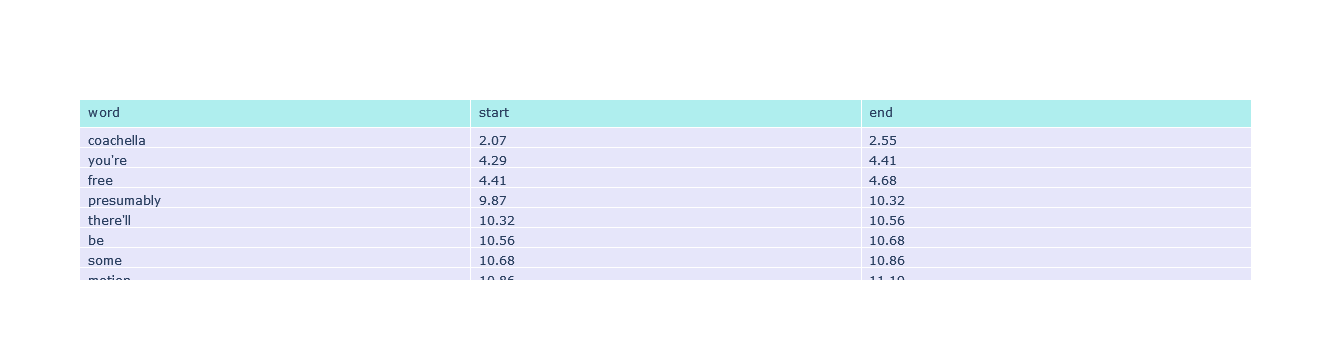

In [16]:
import plotly.graph_objects as go
import pandas as pd

# df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_usa_states.csv')

fig = go.Figure(data=[go.Table(
    header=dict(values=list(word_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[word_df.word, word_df.start, word_df.end],
               fill_color='lavender',
               align='left'))
])

fig.show()

# Read EEG Data using MNE

In [1]:
import mne
import pandas as pd

def read_eeg(vhdr_fname):
    # define list of indicies for non-eeg channels
    misc_list = []
    for i in range(18):
        misc_list.append(i+64)

    # read raw data
    raw = mne.io.read_raw_brainvision(vhdr_fname, misc=misc_list, preload=True,
        verbose=False)
    raw.info['line_freq'] = 500.

    # Set montage
    montage = mne.channels.make_standard_montage('easycap-M1')
    raw.set_montage(montage, verbose=False)

    # Set common average reference
    raw.set_eeg_reference('average', projection=False, verbose=False)

    # create pandas dataframe with eeg data
    eeg_data = pd.DataFrame(raw.get_data().transpose(), columns=raw.ch_names)

    # Temporarily drop T7 while it's broken
    eeg_data = eeg_data.drop(columns=["T7"])

    return eeg_data

In [5]:
vhdr_fname = "../../static/2022_01_14_T05_U002/2022_01_14_T05_U002_EEG01.vhdr"
misc_list = []
for i in range(18):
    misc_list.append(i+64)

# read raw data
raw = mne.io.read_raw_brainvision(vhdr_fname, misc=misc_list, preload=True,
    verbose=False)
raw.info['line_freq'] = 500.

# Set montage
montage = mne.channels.make_standard_montage('easycap-M1')
raw.set_montage(montage, verbose=False)

# Set common average reference
raw.set_eeg_reference('average', projection=False, verbose=False)

<RawBrainVision | 2022_01_14_T05_U002_EEG01.eeg, 82 x 282678 (565.4 s), ~177.0 MB, data loaded>

In [7]:
raw

<RawBrainVision | 2022_01_14_T05_U002_EEG01.eeg, 82 x 282678 (565.4 s), ~177.0 MB, data loaded>

In [8]:
brain_df = read_eeg("../../static/2022_01_14_T05_U002/2022_01_14_T05_U002_EEG01.vhdr")

In [4]:
brain_df.columns

Index(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7',
       'F8', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1',
       'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'FT9', 'FT10', 'FCz', 'AFz', 'F1',
       'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4',
       'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7',
       'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'CPz', 'POz', 'TP10', 'ExG 1',
       'ExG 2', 'ExG 3', 'ExG 4', 'ECG.', 'Resp.', 'PPG', 'SpO2', 'HR', 'GSR',
       'Temp.', 'AUX 1', 'AUX 2', 'ACC77', 'ACC78', 'ACC79', 'Packet Counter',
       'TRIGGER'],
      dtype='object')

In [9]:
from sklearn_som.som import SOM

In [20]:
eeg = brain_df.iloc[:,:63].to_numpy()

In [54]:
bio = brain_df.iloc[:,67:74].to_numpy()

In [65]:
data = bio
brain_som = SOM(m=3, n=1, dim=7)
brain_som.fit(data)
preds = brain_som.predict(data)

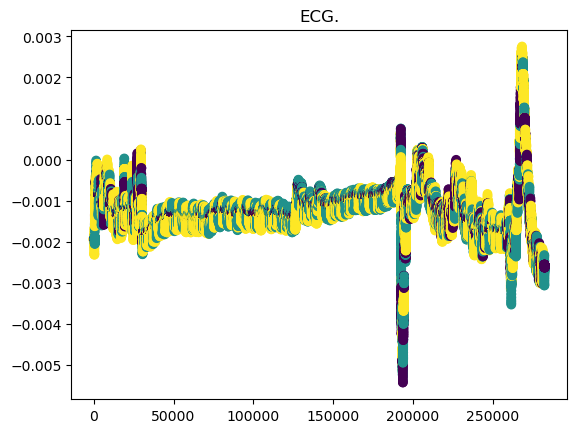

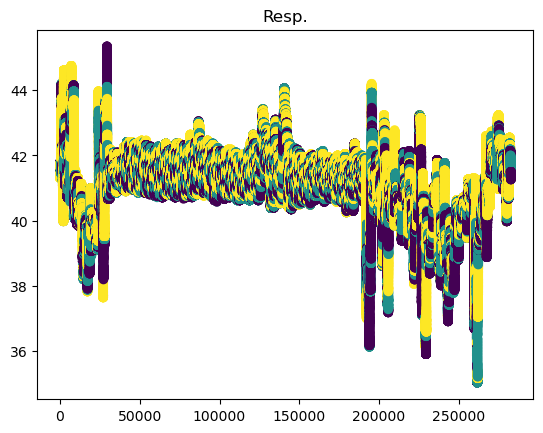

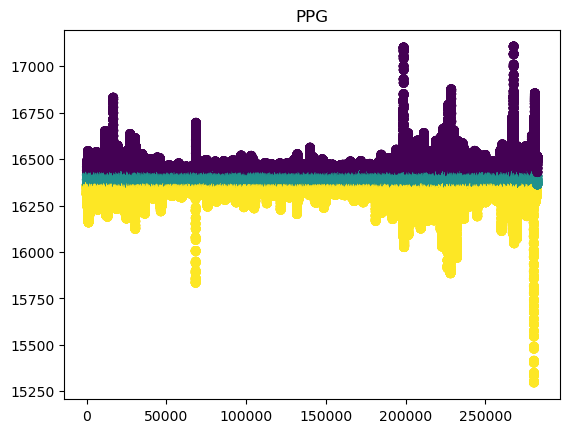

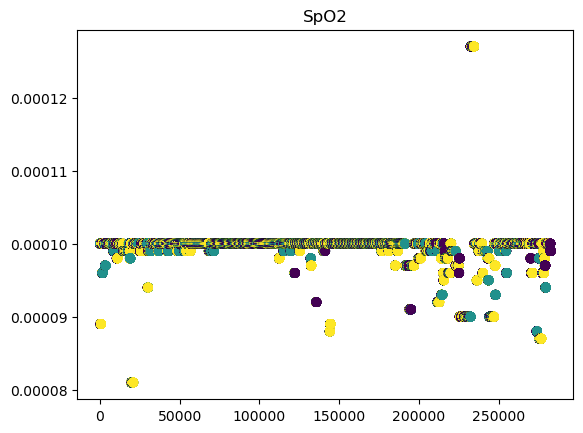

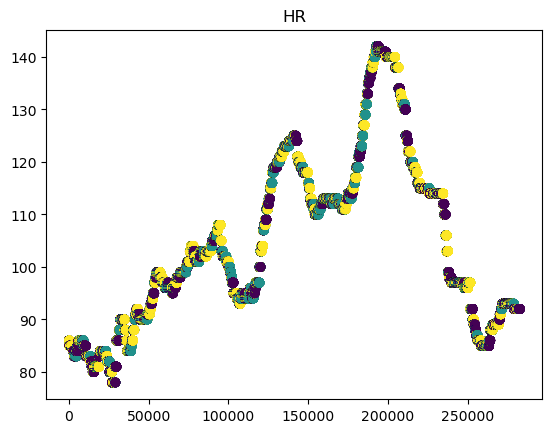

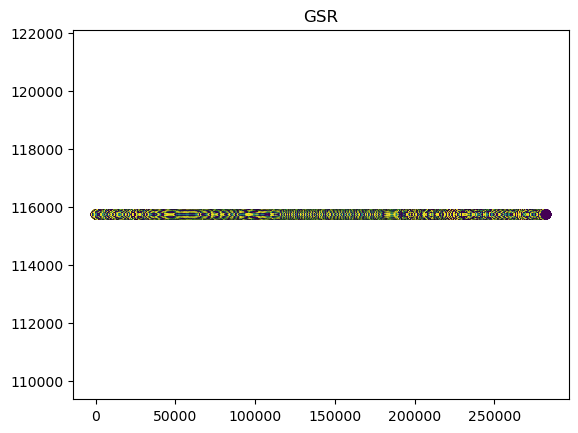

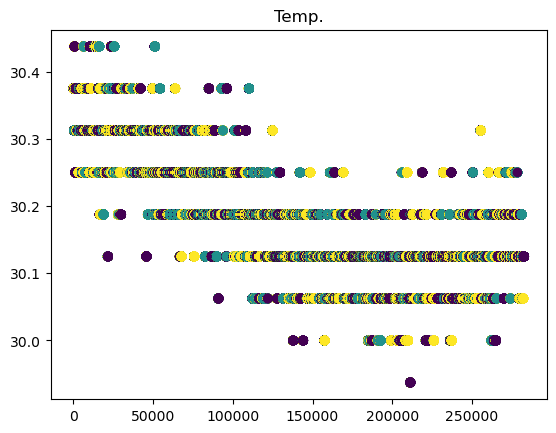

In [66]:
import matplotlib.pyplot as plt
bio_list = ['ECG.', 'Resp.', 'PPG', 'SpO2', 'HR', 'GSR','Temp.']
for i in bio_list:
    plt.figure()
    plt.scatter(brain_df.index, brain_df[i], c=preds)
    plt.title(i)
plt.show()

# AUTOMATE THE BELOW STUFF TO FIGURE OUT EEG TRIGGER POINTS TO ALIGN WITH VIDEO FEED

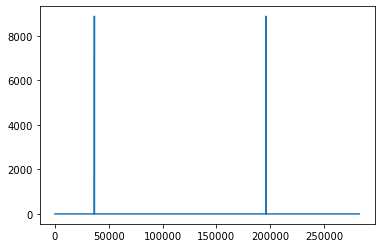

In [57]:
brain_df['TRIGGER'].plot()
import matplotlib.pyplot as plt
plt.show()
%matplotlib inline

In [59]:
brain_df['TRIGGER'].unique()

array([2.000e+00, 3.000e+00, 8.888e+03])

In [61]:
import numpy as np

np.where(brain_df['TRIGGER'] == 8888)

(array([ 36582,  36583,  36584,  36585,  36586,  36587,  36588,  36589,
         36590,  36591,  36592,  36593,  36594,  36595,  36596,  36597,
         36598,  36599,  36600,  36601,  36602,  36603,  36604,  36605,
         36606,  36607,  36608,  36609,  36610,  36611,  36612,  36613,
         36614,  36615,  36616,  36617,  36618,  36619,  36620,  36621,
         36622,  36623,  36624,  36625,  36626,  36627,  36628,  36629,
         36630,  36631,  36632,  36633,  36634,  36635,  36636,  36637,
         36638,  36639,  36640,  36641,  36642,  36643,  36644,  36645,
         36646,  36647,  36648,  36649,  36650,  36651,  36652,  36653,
         36654,  36655,  36656,  36657,  36658,  36659,  36660, 195796,
        195797, 195798, 195799, 195800, 195801, 195802, 195803, 195804,
        195805, 195806, 195807, 195808, 195809, 195810, 195811, 195812,
        195813, 195814, 195815, 195816, 195817, 195818, 195819, 195820,
        195821, 195822, 195823, 195824, 195825, 195826, 195827, 

In [72]:
word_df

word   start     end
0     coachella    2.07    2.55
1        you're    4.29    4.41
2          free    4.41    4.68
3    presumably    9.87   10.32
4      there'll   10.32   10.56
..          ...     ...     ...
360    calories  511.26  511.98
361     because  512.31  512.70
362          of  512.70  513.09
363        just  513.60  513.93
364         the  513.93  514.16

[365 rows x 3 columns]

In [79]:
word_df.iloc[3:,:].reset_index().drop('index', axis=1)

word   start     end
0    presumably    9.87   10.32
1      there'll   10.32   10.56
2            be   10.56   10.68
3          some   10.68   10.86
4        motion   10.86   11.19
..          ...     ...     ...
357    calories  511.26  511.98
358     because  512.31  512.70
359          of  512.70  513.09
360        just  513.60  513.93
361         the  513.93  514.16

[362 rows x 3 columns]

In [68]:
36653/500

73.306

In [69]:
43.59-43.2888

0.30120000000000147

In [71]:
30.12*500

15060.0

In [67]:
brain_df.columns

Index(['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7',
       'F8', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1',
       'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'FT9', 'FT10', 'FCz', 'AFz', 'F1',
       'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4',
       'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7',
       'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Fpz', 'CPz', 'POz', 'TP10', 'ExG 1',
       'ExG 2', 'ExG 3', 'ExG 4', 'ECG.', 'Resp.', 'PPG', 'SpO2', 'HR', 'GSR',
       'Temp.', 'AUX 1', 'AUX 2', 'ACC77', 'ACC78', 'ACC79', 'Packet Counter',
       'TRIGGER'],
      dtype='object')